In [1]:
import yfinance as yf
import pandas   as pd
import numpy    as np 
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rcParams['figure.figsize'] = (20,10)

In [3]:
btcorig = yf.Ticker("BTC-USD").history(period="30y")

In [4]:
NOTHING = 2
BUY = 1
SELL = 0

In [5]:
def backtester(signals, price, tcost = 0.002):

    pos_val = np.zeros(np.shape(price))
    cash    = np.zeros(np.shape(price))
    cash[0] = 1

    for i,val in enumerate(price):
        if i == len(price)-1:
            break
        if signals[i] == SELL:
            cash[i+1] = (pos_val[i] * val * (1-tcost)) + cash[i]
            pos_val[i+1] = 0
        elif signals[i] == BUY:
            pos_val[i+1] = ((cash[i] / val)* (1-tcost)) + pos_val[i]
            cash[i+1] = 0
        else:
            pos_val[i+1] = pos_val[i]
            cash[i+1] = cash[i]

    returns = [a*b for a,b in zip(pos_val,price)] + cash

    return returns

In [6]:
def sma(price, window = 25):
    price_sma = price.rolling(window).mean()

    signals = []
    for i in range(len(price)):
        if price_sma[i] > price[i]:
            signals.append(SELL)
        elif price_sma[i] < price[i]:
            signals.append(BUY)
        else:
            signals.append(BUY)
            #signals.append(NOTHING)

    return signals

In [7]:
btc = btcorig['Close'].to_frame().copy()

In [8]:
display(btc)

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2022-08-25,21600.904297
2022-08-26,20260.019531
2022-08-27,20041.738281


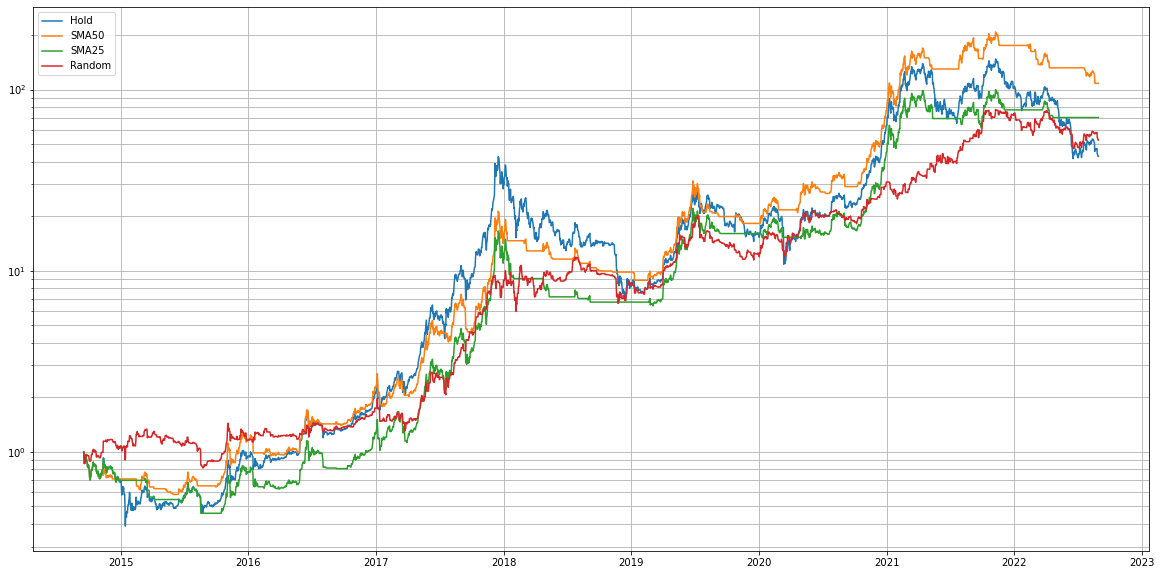

In [9]:
tcost = 0.001 # binance fees

name = 'Hold'
signals = np.full(len(btc), BUY)
signals[0] = BUY
signals[-2] = SELL
btc[f'Signals{name}'] = signals
btc[f'Returns{name}'] = returns = backtester(btc[f'Signals{name}'], btc['Close'], tcost=tcost)
plt.plot(btc.index, returns, label=name)

name = 'SMA50'
btc[f'Signals{name}'] = signals = sma(btc['Close'], 50)
btc[f'Returns{name}'] = returns = backtester(btc[f'Signals{name}'], btc['Close'], tcost=tcost)
plt.plot(btc.index, returns, label=name)

name = 'SMA25'
btc[f'Signals{name}'] = signals = sma(btc['Close'], 100)
btc[f'Returns{name}'] = returns = backtester(btc[f'Signals{name}'], btc['Close'], tcost=tcost)
plt.plot(btc.index, returns, label=name)

name = 'Random'
btc[f'Signals{name}'] = signals = np.random.randint(SELL, BUY+1, len(btc))
btc[f'Returns{name}'] = returns = backtester(btc[f'Signals{name}'], btc['Close'], tcost=tcost)
plt.plot(btc.index, returns, label=name)

plt.legend()
plt.grid(True, 'both')
plt.yscale('log')
# plt.ylim(0.1, 500)
plt.show()

In [10]:
def win_rate(sigs, returns):
    tps = []
    sigs = sigs[1:-1]
    rets = (returns.pct_change()).shift(1).dropna().values.ravel()
    for i,val in enumerate(sigs):
        if ((sigs[i] == BUY) and rets[i]>0):
            tps.append(1)
    win_rate = sum(tps)/len(sigs)
    return win_rate

name = 'Hold'
print(name, win_rate(btc[f'Signals{name}'], btc[f'Returns{name}'] ))
name = 'SMA25'
print(name, win_rate(btc[f'Signals{name}'], btc[f'Returns{name}'] ))
name = 'SMA50'
print(name, win_rate(btc[f'Signals{name}'], btc[f'Returns{name}'] ))
name = 'Random'
print(name, win_rate(btc[f'Signals{name}'], btc[f'Returns{name}'] ))

Hold 0.5365265334252239
SMA25 0.32598208132322537
SMA50 0.32046864231564437
Random 0.1485182632667126


In [11]:
def max_dd(returns, window=None):

    data = (1+pd.Series(returns)).cumprod()

    if window is not None:
        roll_max = data.rolling(window, min_periods=1).max()
    else:
        roll_max = data.expanding().max()

    daily = data/roll_max - 1.0

    return min(daily)

In [12]:
max_dd(btc['Close'].pct_change().dropna())

-0.8339900882218972

# Lets find the lowest drawdown & best win rate for SMA

In [13]:
sma_windows = np.arange(5,205,5)

drawdowns = []
win_rates = []

for i in sma_windows:
    
    signals = sma(btc['Close'], i)
    returns = backtester(signals, btc['Close'])
    
    drawdowns.append(max_dd(pd.Series(returns).pct_change().dropna().values.ravel()))
    win_rates.append(win_rate(signals, pd.Series(returns)))

In [14]:
sma_windows[drawdowns.index(max(drawdowns))]

25

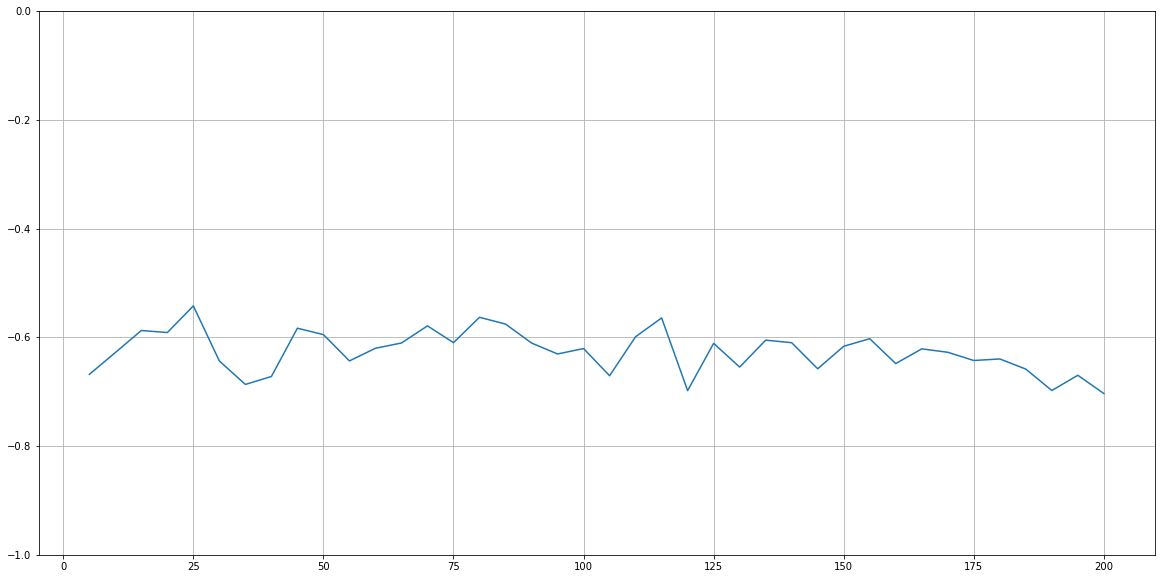

In [21]:
plt.plot(sma_windows, drawdowns)
plt.ylim(-1, 0)
plt.grid(True, 'both')
plt.show()

In [16]:
max(drawdowns)

-0.5421211998607431

In [17]:
sma_windows[win_rates.index(max(win_rates))]

200

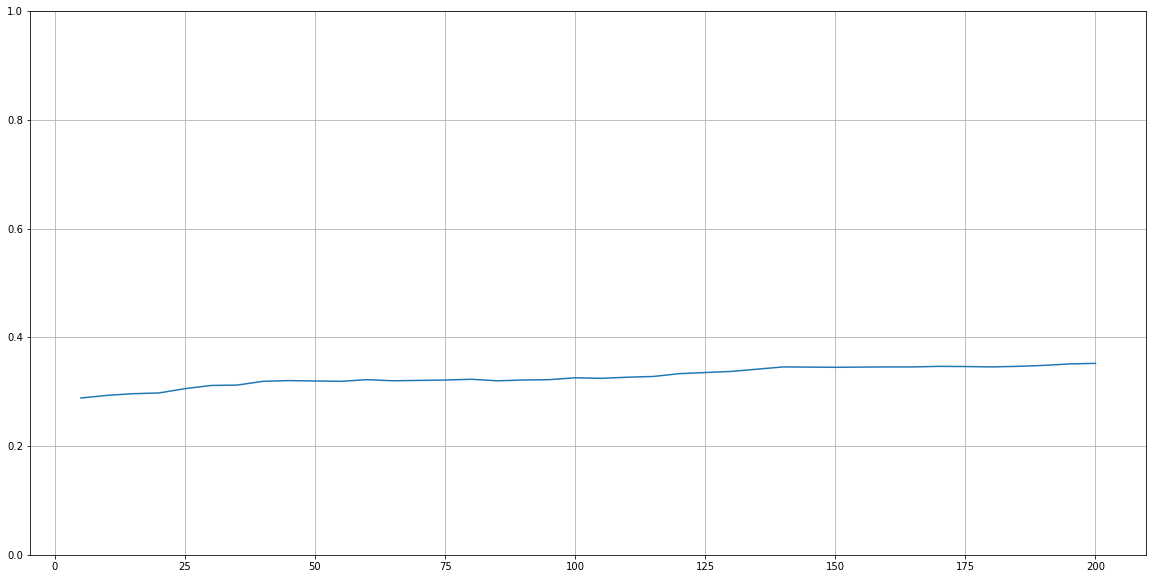

In [22]:
plt.plot(sma_windows, win_rates)
plt.ylim(0, 1)
plt.grid(True, 'both')
plt.show()

max(win_rates)